Anzahl Klassen im Target: 4
label_majority
2.0    4876
1.0    1619
4.0    1322
3.0    1053
Name: count, dtype: int64
Training Random Forest model...
Accuracy: 0.7999
Precision: 0.7994
Recall: 0.7999
F1-Score: 0.7958
CV Score: 0.7903 (+/- 0.0282)

Detailed Classification Report:
----------------------------------------
              precision    recall  f1-score   support

         1.0       0.75      0.60      0.67       324
         2.0       0.80      0.90      0.84       975
         3.0       0.82      0.75      0.79       211
         4.0       0.85      0.73      0.78       264

    accuracy                           0.80      1774
   macro avg       0.80      0.74      0.77      1774
weighted avg       0.80      0.80      0.80      1774


RANDOM FOREST RESULTS SUMMARY
Accuracy       : 0.7999
Precision      : 0.7994
Recall         : 0.7999
F1-Score       : 0.7958
CV Mean        : 0.7903
CV Std         : 0.0141


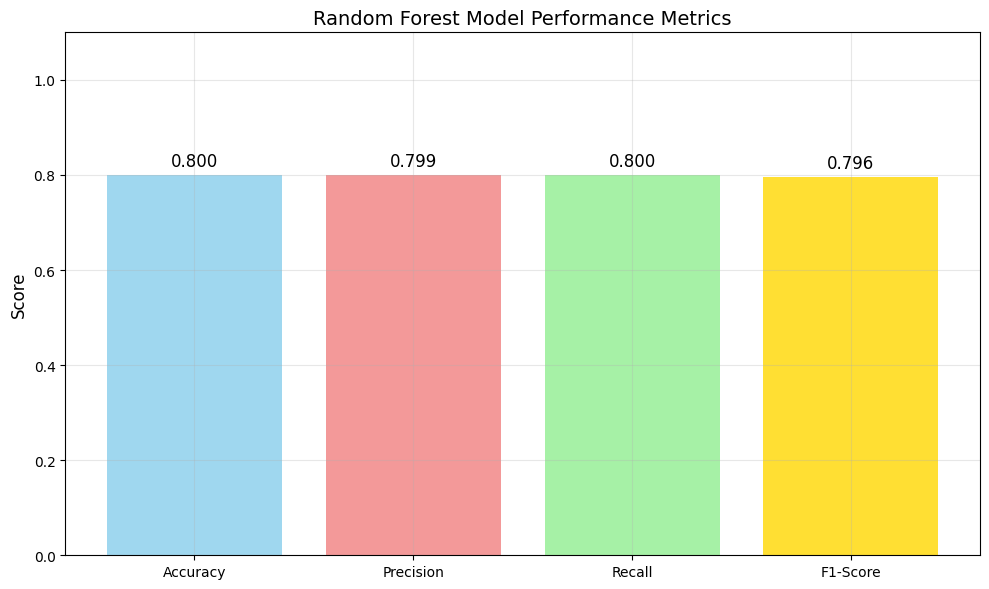

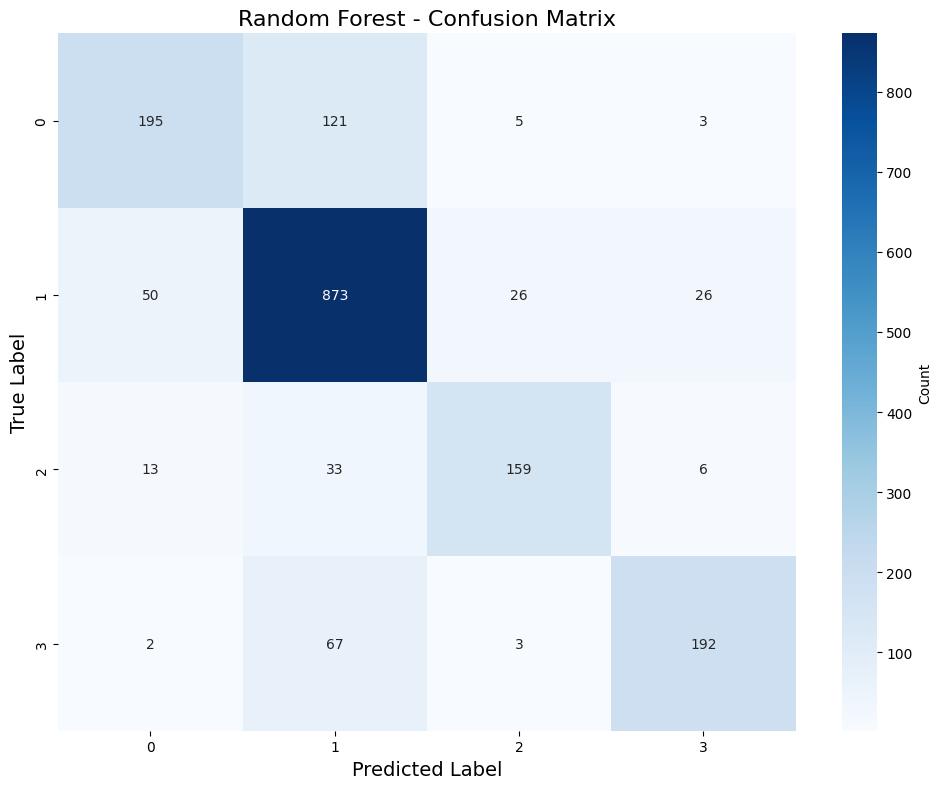

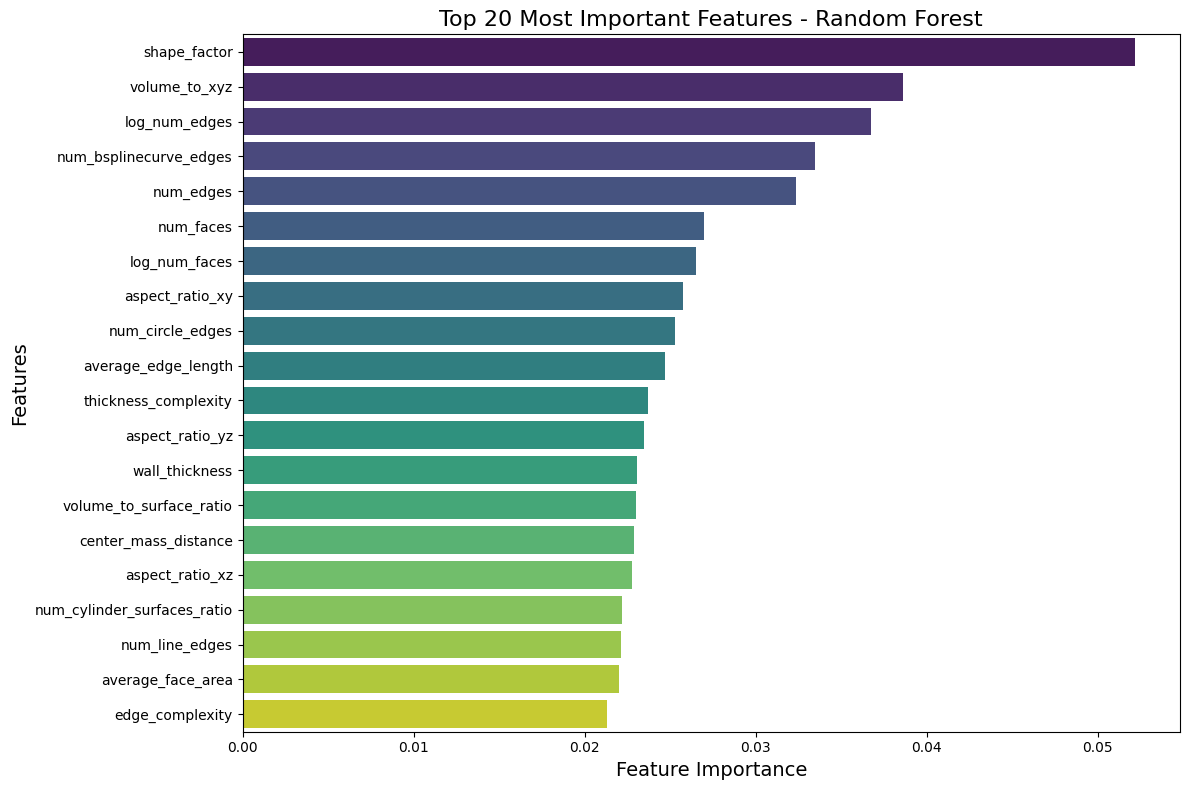


Top 20 Feature Importances:
--------------------------------------------------
shape_factor                   0.0522
volume_to_xyz                  0.0386
log_num_edges                  0.0367
num_bsplinecurve_edges         0.0335
num_edges                      0.0324
num_faces                      0.0270
log_num_faces                  0.0265
aspect_ratio_xy                0.0258
num_circle_edges               0.0253
average_edge_length            0.0247
thickness_complexity           0.0237
aspect_ratio_yz                0.0235
wall_thickness                 0.0231
volume_to_surface_ratio        0.0230
center_mass_distance           0.0229
aspect_ratio_xz                0.0228
num_cylinder_surfaces_ratio    0.0222
num_line_edges                 0.0221
average_face_area              0.0220
edge_complexity                0.0213


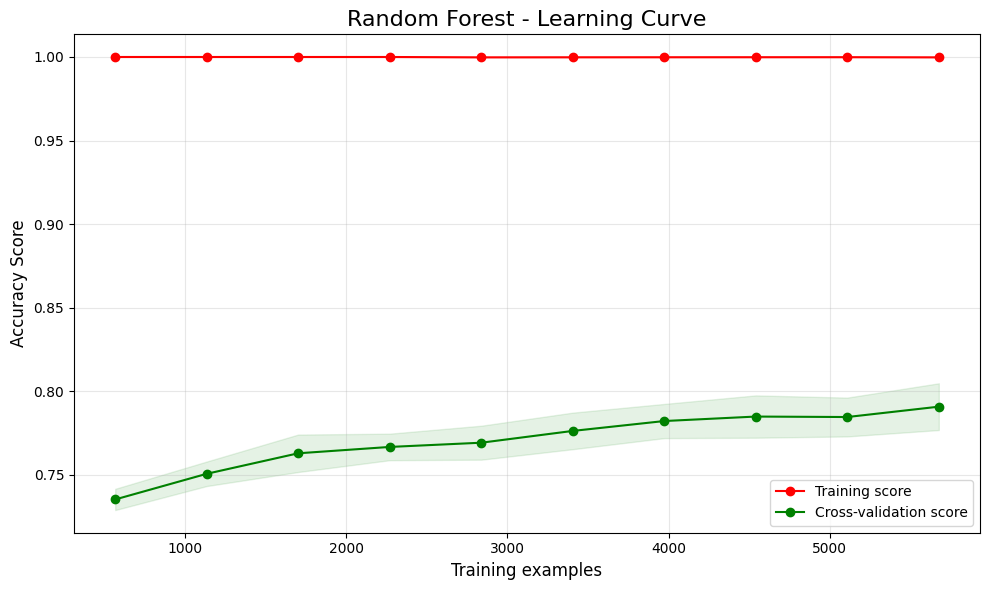

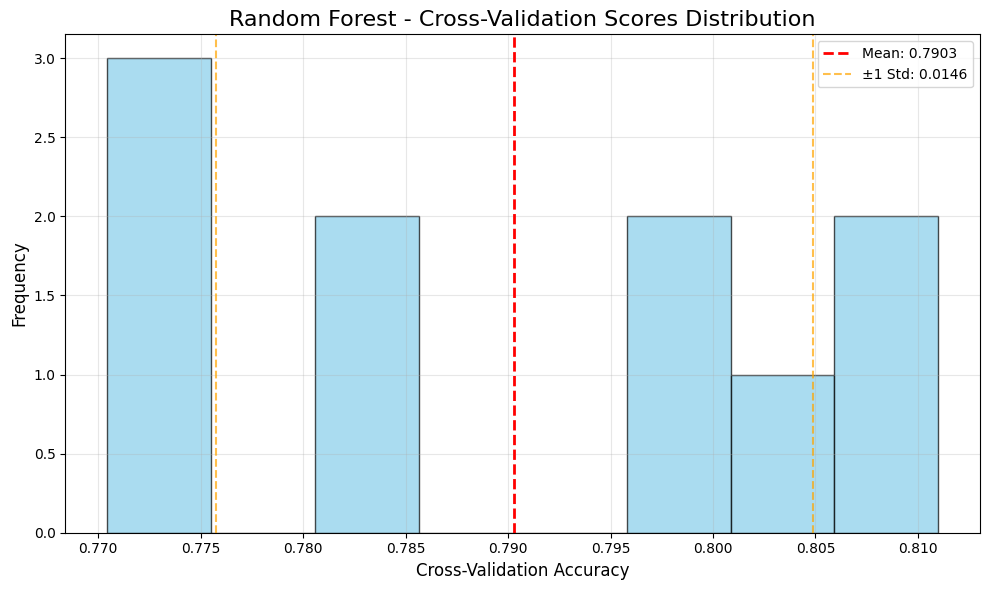


Performing hyperparameter tuning for Random Forest...
Parameter grid: {'n_estimators': [50, 100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2', None], 'bootstrap': [True, False]}
This may take a while...
Fitting 5 folds for each of 864 candidates, totalling 4320 fits

Tuning Results:
Base accuracy: 0.7999
Tuned accuracy: 0.7976
Improvement: -0.0023
Best CV score: 0.7947
Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


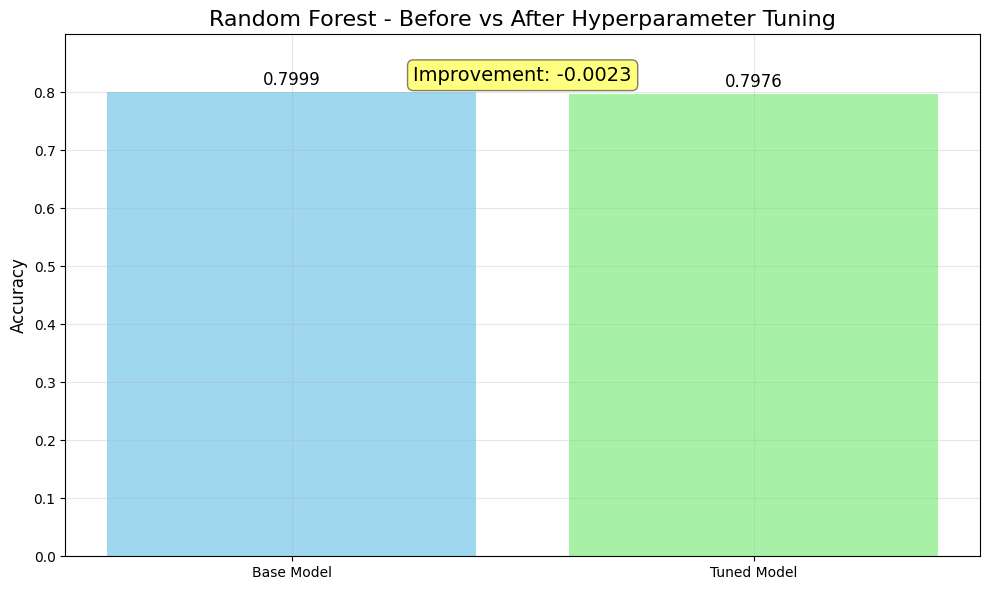


Best model ready for deployment!
Uncomment the joblib.dump lines to save the model and scaler.

Random Forest analysis complete!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import gc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

warnings.filterwarnings('ignore')

class DataLoaderAndPreprocessor:
    def __init__(self, file_path, sample_size=None):
        self.file_path = file_path
        self.sample_size = sample_size

    def safe_divide(self, a, b):
        a = a.astype(np.float64)
        b = b.astype(np.float64)
        return np.divide(a, b, out=np.zeros_like(a, dtype=np.float64), where=b != 0)

    def calculate_features(self, data):
        data = data.copy()
        numeric_columns = data.select_dtypes(include=[np.number]).columns
        data[numeric_columns] = data[numeric_columns].astype(np.float64)

        features_to_calculate = [
            ('volume_to_surface_ratio', 'volume', 'surface_area'),
            ('edge_to_face_ratio', 'num_edges', 'num_faces'),
            ('average_face_area', 'surface_area', 'num_faces'),
            ('edge_complexity', 'num_edges', 'num_faces'),
            ('surface_complexity', 'num_unique_normals', 'num_faces'),
            ('thickness_complexity', 'wall_thickness', 'num_faces')
        ]

        for new_feat, num, denom in features_to_calculate:
            data[new_feat] = self.safe_divide(data[num].values, data[denom].values)

        data['average_edge_length'] = self.safe_divide(
            data[['x_dim', 'y_dim', 'z_dim']].sum(axis=1).values,
            data['num_edges'].values
        )

        volume_pow = np.power(data['volume'].values, 2/3)
        data['shape_factor'] = self.safe_divide(data['surface_area'].values, volume_pow)

        for prefix, columns in [
            ('edge', ['num_line_edges', 'num_circle_edges', 'num_ellipse_edges', 'num_bsplinecurve_edges']),
            ('surface', ['num_plane_surfaces', 'num_cylinder_surfaces', 'num_cone_surfaces',
                         'num_sphere_surfaces', 'num_torus_surfaces', 'num_bspline_surfaces'])
        ]:
            total = data[columns].sum(axis=1).values
            for col in columns:
                data[f'{col}_ratio'] = self.safe_divide(data[col].values, total)

        data['aspect_ratio_xy'] = self.safe_divide(data['x_dim'].values, data['y_dim'].values)
        data['aspect_ratio_xz'] = self.safe_divide(data['x_dim'].values, data['z_dim'].values)
        data['aspect_ratio_yz'] = self.safe_divide(data['y_dim'].values, data['z_dim'].values)

        xyz_product = data['x_dim'].values * data['y_dim'].values * data['z_dim'].values
        data['volume_to_xyz'] = self.safe_divide(data['volume'].values, xyz_product)
        data['surface_to_xyz'] = self.safe_divide(data['surface_area'].values, xyz_product)

        center_cols = ['x_center_mass_relative', 'y_center_mass_relative', 'z_center_mass_relative']
        center_mass_coords = data[center_cols].values - 0.5
        data['center_mass_distance'] = np.linalg.norm(center_mass_coords, axis=1)

        for col in ['volume', 'surface_area', 'num_faces', 'num_edges']:
            min_positive = max(data[col].min(), 1e-10)
            data[f'log_{col}'] = np.log1p(data[col].clip(lower=min_positive))

        complexity_cols = ['edge_complexity', 'surface_complexity', 'thickness_complexity']
        data['overall_complexity'] = data[complexity_cols].clip(lower=0).mean(axis=1)

        return data.replace([np.inf, -np.inf], 0).fillna(0)

    def load_data(self):
        df = pd.read_csv(self.file_path)
        df = df[(df['volume'] > 0) & (df['surface_area'] > 0)].copy()
        if 'filename' in df.columns:
            df.drop(columns=['filename'], inplace=True)

        if self.sample_size and self.sample_size < 1.0:
            df = df.groupby('label_majority').apply(
                lambda x: x.sample(frac=self.sample_size, random_state=42)
            ).reset_index(drop=True)

        df = self.calculate_features(df)
        print(f"Anzahl Klassen im Target: {df['label_majority'].nunique()}")
        print(df['label_majority'].value_counts())
        return df

class RandomForestEvaluator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.results = {}
        self.scaler = StandardScaler()
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, stratify=self.y, random_state=42
        )
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        # Nur Random Forest Klassifikator
        self.rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    def train_and_evaluate(self):
        print("Training Random Forest model...")
        print("=" * 60)
        
        # Training
        self.rf_model.fit(self.X_train_scaled, self.y_train)
        
        # Vorhersagen
        self.y_pred = self.rf_model.predict(self.X_test_scaled)

        # Metriken berechnen
        accuracy = accuracy_score(self.y_test, self.y_pred)
        precision = precision_score(self.y_test, self.y_pred, average='weighted')
        recall = recall_score(self.y_test, self.y_pred, average='weighted')
        f1 = f1_score(self.y_test, self.y_pred, average='weighted')
        
        # Cross-Validation
        cv_scores = cross_val_score(self.rf_model, self.X_train_scaled, self.y_train, cv=5, scoring='accuracy')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()

        self.results = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'CV Mean': cv_mean,
            'CV Std': cv_std
        }

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"CV Score: {cv_mean:.4f} (+/- {cv_std * 2:.4f})")

        # Detaillierter Classification Report
        print("\nDetailed Classification Report:")
        print("-" * 40)
        print(classification_report(self.y_test, self.y_pred))

        return self.results

    def get_feature_importance(self):
        """Extrahiert Feature Importance"""
        feature_importance = pd.DataFrame({
            'feature': self.X.columns,
            'importance': self.rf_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        return feature_importance

class RandomForestVisualizer:
    def __init__(self, evaluator, feature_names):
        self.evaluator = evaluator
        self.feature_names = feature_names
        self.results = evaluator.results
        self.rf_model = evaluator.rf_model
        self.y_test = evaluator.y_test
        self.y_pred = evaluator.y_pred
        self.X_train_scaled = evaluator.X_train_scaled
        self.y_train = evaluator.y_train

    def plot_metrics(self):
        """Visualisiert alle Metriken"""
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        values = [self.results[metric] for metric in metrics]
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(metrics, values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'], alpha=0.8)
        
        # Füge Werte auf den Balken hinzu
        for bar, value in zip(bars, values):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                     f'{value:.3f}', ha='center', va='bottom', fontsize=12)
        
        plt.ylim(0, 1.1)
        plt.ylabel('Score', fontsize=12)
        plt.title('Random Forest Model Performance Metrics', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self):
        """Confusion Matrix"""
        cm = confusion_matrix(self.y_test, self.y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    cbar_kws={'label': 'Count'})
        plt.title('Random Forest - Confusion Matrix', fontsize=16)
        plt.xlabel('Predicted Label', fontsize=14)
        plt.ylabel('True Label', fontsize=14)
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, top_n=20):
        """Feature Importance Plot"""
        feature_importance = self.evaluator.get_feature_importance()
        
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(top_n)
        sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
        plt.title(f'Top {top_n} Most Important Features - Random Forest', fontsize=16)
        plt.xlabel('Feature Importance', fontsize=14)
        plt.ylabel('Features', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # Zeige auch die Zahlen
        print(f"\nTop {top_n} Feature Importances:")
        print("-" * 50)
        for idx, row in top_features.iterrows():
            print(f"{row['feature']:<30} {row['importance']:.4f}")

    def plot_learning_curve(self):
        """Learning Curve"""
        train_sizes, train_scores, test_scores = learning_curve(
            self.rf_model, self.X_train_scaled, self.y_train, 
            cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), 
            scoring='accuracy'
        )

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        
        plt.xlabel("Training examples", fontsize=12)
        plt.ylabel("Accuracy Score", fontsize=12)
        plt.title("Random Forest - Learning Curve", fontsize=16)
        plt.legend(loc="best")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plot_cv_scores_distribution(self):
        """Cross-Validation Scores Distribution"""
        cv_scores = cross_val_score(self.rf_model, self.X_train_scaled, self.y_train, cv=10, scoring='accuracy')
        
        plt.figure(figsize=(10, 6))
        plt.hist(cv_scores, bins=8, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(cv_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cv_scores.mean():.4f}')
        plt.axvline(cv_scores.mean() - cv_scores.std(), color='orange', linestyle='--', alpha=0.7, label=f'±1 Std: {cv_scores.std():.4f}')
        plt.axvline(cv_scores.mean() + cv_scores.std(), color='orange', linestyle='--', alpha=0.7)
        
        plt.xlabel('Cross-Validation Accuracy', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title('Random Forest - Cross-Validation Scores Distribution', fontsize=16)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

class RandomForestTuner:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.tuned_results = {}
        
        # Umfangreiches Parameter-Grid für Random Forest
        self.param_grid = {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False]
        }

    def tune_hyperparameters(self):
        """Hyperparameter-Tuning mit GridSearchCV"""
        print("\nPerforming hyperparameter tuning for Random Forest...")
        print("=" * 60)
        print("Parameter grid:", self.param_grid)
        print("This may take a while...")
        
        # Base Model für Vergleich
        base_rf = RandomForestClassifier(random_state=42)
        base_rf.fit(self.X_train, self.y_train)
        base_accuracy = accuracy_score(self.y_test, base_rf.predict(self.X_test))
        
        # Grid Search
        grid_search = GridSearchCV(
            RandomForestClassifier(random_state=42),
            self.param_grid,
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(self.X_train, self.y_train)
        
        # Evaluation des optimierten Modells
        best_model = grid_search.best_estimator_
        y_pred_tuned = best_model.predict(self.X_test)
        tuned_accuracy = accuracy_score(self.y_test, y_pred_tuned)
        
        self.tuned_results = {
            'Base Accuracy': base_accuracy,
            'Tuned Accuracy': tuned_accuracy,
            'Improvement': tuned_accuracy - base_accuracy,
            'Best Parameters': grid_search.best_params_,
            'Best CV Score': grid_search.best_score_,
            'Best Model': best_model
        }
        
        print(f"\nTuning Results:")
        print(f"Base accuracy: {base_accuracy:.4f}")
        print(f"Tuned accuracy: {tuned_accuracy:.4f}")
        print(f"Improvement: {tuned_accuracy - base_accuracy:.4f}")
        print(f"Best CV score: {grid_search.best_score_:.4f}")
        print(f"Best parameters: {grid_search.best_params_}")
        
        return self.tuned_results

    def plot_tuning_results(self):
        """Visualisiert die Tuning-Ergebnisse"""
        if not self.tuned_results:
            print("No tuning results available.")
            return
        
        # Balkendiagramm: Vorher vs. Nachher
        plt.figure(figsize=(10, 6))
        categories = ['Base Model', 'Tuned Model']
        accuracies = [self.tuned_results['Base Accuracy'], self.tuned_results['Tuned Accuracy']]
        colors = ['skyblue', 'lightgreen']
        
        bars = plt.bar(categories, accuracies, color=colors, alpha=0.8)
        
        # Füge Werte auf den Balken hinzu
        for bar, acc in zip(bars, accuracies):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                     f'{acc:.4f}', ha='center', va='bottom', fontsize=12)
        
        # Verbesserung als Text
        improvement = self.tuned_results['Improvement']
        plt.text(0.5, max(accuracies) + 0.02, 
                f'Improvement: {improvement:.4f}', 
                ha='center', fontsize=14, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))
        
        plt.ylabel('Accuracy', fontsize=12)
        plt.title('Random Forest - Before vs After Hyperparameter Tuning', fontsize=16)
        plt.ylim(0, max(accuracies) + 0.1)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    # Hauptausführung
    file_path = r"C:\\Users\\meh91075\\Downloads\\features_newWallthickness_16092024.csv"
    
    # Daten laden und vorverarbeiten
    data_handler = DataLoaderAndPreprocessor(file_path, sample_size=0.5)
    df = data_handler.load_data()

    # Features und Target vorbereiten
    X = df.drop(columns=['label_majority'])
    y = df['label_majority']
    feature_names = X.columns.tolist()

    # Random Forest Training und Evaluation
    evaluator = RandomForestEvaluator(X, y)
    results = evaluator.train_and_evaluate()
    
    # Ergebnisse anzeigen
    print("\n" + "=" * 60)
    print("RANDOM FOREST RESULTS SUMMARY")
    print("=" * 60)
    for metric, value in results.items():
        print(f"{metric:<15}: {value:.4f}")

    # Visualisierungen
    visualizer = RandomForestVisualizer(evaluator, feature_names)
    visualizer.plot_metrics()
    visualizer.plot_confusion_matrix()
    visualizer.plot_feature_importance(top_n=20)
    visualizer.plot_learning_curve()
    visualizer.plot_cv_scores_distribution()

    # Hyperparameter-Tuning
    tuner = RandomForestTuner(
        evaluator.X_train_scaled, 
        evaluator.y_train, 
        evaluator.X_test_scaled, 
        evaluator.y_test
    )
    
    tuning_results = tuner.tune_hyperparameters()
    tuner.plot_tuning_results()

    # Speichere das beste Modell
    if 'Best Model' in tuning_results:
        best_model = tuning_results['Best Model']
        # joblib.dump(best_model, 'best_random_forest_model.pkl')
        # joblib.dump(evaluator.scaler, 'feature_scaler.pkl')
        print("\nBest model ready for deployment!")
        print("Uncomment the joblib.dump lines to save the model and scaler.")

    print("\nRandom Forest analysis complete!")